# LSTM 3D

### LIBRERIAS

In [1]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### CARGA DE DATOS
#### Normales

In [41]:
completeRentalsExogDf = pd.read_csv('../data/completeData/rentals/completeRentalsDf_EXOGVAR.csv')
completeReturnsExogDf = pd.read_csv('../data/completeData/returns/completeReturnsDf_EXOGVAR.csv')
completeRentalsExogDf.set_index('Date', inplace=True)
completeReturnsExogDf.set_index('Date', inplace=True)
completeRentalsExogDf.drop('Date.1', inplace=True, axis=1)
completeReturnsExogDf.drop('Date.1', inplace=True, axis=1)

In [42]:
completeRentalsDf = pd.read_csv('../data/completeData/rentals/completeRentalsDf.csv')
completeReturnsDf = pd.read_csv('../data/completeData/returns/completeReturnsDf.csv')
completeRentalsDf.set_index('Date', inplace=True)
completeReturnsDf.set_index('Date', inplace=True)

#### LOG1P

In [20]:
completeRentalsExogDf = pd.read_csv('../data/completeData/rentals/completeRentalsDf_LOG1P_EXOGVAR.csv')
completeReturnsExogDf = pd.read_csv('../data/completeData/returns/completeReturnsDf_LOG1P_EXOGVAR.csv')
completeRentalsExogDf.set_index('Date', inplace=True)
completeReturnsExogDf.set_index('Date', inplace=True)
completeRentalsExogDf.drop('Date.1', inplace=True, axis=1)
completeReturnsExogDf.drop('Date.1', inplace=True, axis=1)

In [21]:
completeRentalsDf = pd.read_csv('../data/completeData/rentals/completeRentalsDf_LOG1P.csv')
completeReturnsDf = pd.read_csv('../data/completeData/returns/completeReturnsDf_LOG1P.csv')
completeRentalsDf.set_index('Date', inplace=True)
completeReturnsDf.set_index('Date', inplace=True)

### CREACION DE LOS CONJUNTOS TRAIN/VALIDATION/TEST

In [22]:
Xrentals = completeRentalsExogDf.drop(completeRentalsDf.columns, axis=1)

Xweather = Xrentals.transpose().iloc[len(Xrentals.transpose())-33:len(Xrentals.transpose())].transpose()
Xrentals = Xrentals.add_suffix('_rentals').transpose()
Xrentals = Xrentals.iloc[0:len(Xrentals)-33,:].transpose()

Xreturns = completeReturnsExogDf.drop(completeReturnsDf.columns, axis=1)
Xreturns = Xreturns.add_suffix('_returns').transpose()
Xreturns = Xreturns.iloc[0:len(Xreturns)-33,:].transpose()

X = Xrentals.join(Xreturns).join(Xweather)

Yrentals = completeRentalsDf[168:].add_suffix('_rentals')
Yreturns = completeReturnsDf[168:].add_suffix('_returns')

Y = Yrentals.join(Yreturns)

print("Shape del dataframe 'X' --> {}".format(X.shape))
print("Shape del dataframe 'Y' --> {}".format(Y.shape))

Shape del dataframe 'X' --> (100896, 4197)
Shape del dataframe 'Y' --> (100896, 1388)


In [23]:
X.head(5)

,0_lag24_rentals,31000_lag24_rentals,31001_lag24_rentals,31002_lag24_rentals,31003_lag24_rentals,31004_lag24_rentals,31005_lag24_rentals,31006_lag24_rentals,31007_lag24_rentals,31008_lag24_rentals,...,Holiday,After-Holiday,System OOS,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
Date,,,,,,,,,,,,,,,,,,,,,
2010-09-27 00:00:00,0.0,0.0,0.0,0.000000,0.0,0.693147,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2010-09-27 01:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2010-09-27 02:00:00,0.0,0.0,0.0,0.693147,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2010-09-27 03:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2010-09-27 04:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [24]:
Y.head(5)

,0_rentals,31000_rentals,31001_rentals,31002_rentals,31003_rentals,31004_rentals,31005_rentals,31006_rentals,31007_rentals,31008_rentals,...,32600_returns,32601_returns,32602_returns,32603_returns,32604_returns,32605_returns,32606_returns,32607_returns,32608_returns,32609_returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-09-27 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-09-27 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-09-27 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-09-27 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-09-27 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
TRAIN_DAYS = 4000
VALIDATION_DAYS = 102

X_train = X[0:TRAIN_DAYS*24]
X_validation = X[TRAIN_DAYS*24:(TRAIN_DAYS+VALIDATION_DAYS)*24]
X_test = X[(TRAIN_DAYS+VALIDATION_DAYS)*24:X.shape[0]]

Y_train = Y[0:TRAIN_DAYS*24]
Y_validation = Y[TRAIN_DAYS*24:(TRAIN_DAYS+VALIDATION_DAYS)*24]
Y_test = Y[(TRAIN_DAYS+VALIDATION_DAYS)*24:X.shape[0]]

print("Shape del dataframe 'X_train' --> {} // 'X_validation --> {} //  X_test --> {}".format(X_train.shape,X_validation.shape, X_test.shape))
print("Shape del dataframe 'Y_train' --> {} // 'Y_validation --> {} // Y_test --> {}".format(Y_train.shape, Y_validation.shape, Y_test.shape))

Shape del dataframe 'X_train' --> (96000, 4197) // 'X_validation --> (2448, 4197) //  X_test --> (2448, 4197)
Shape del dataframe 'Y_train' --> (96000, 1388) // 'Y_validation --> (2448, 1388) // Y_test --> (2448, 1388)


In [26]:
Y_validation_indexes = Y_validation.index.values
Y_validation_columns = Y_validation.columns
Y_test_indexes = Y_test.index.values
Y_test_columns = Y_test.columns

In [27]:
X_train = X_train.to_numpy().reshape(int(len(X_train)/24), -1, X_train.shape[1])
X_validation = X_validation.to_numpy().reshape(int(len(X_validation) / 24), -1, X_validation.shape[1])
X_test = X_test.to_numpy().reshape(int(len(X_test) / 24), -1, X_test.shape[1])

Y_train = Y_train.to_numpy().reshape(int(len(Y_train)/24), -1, Y_train.shape[1])
Y_validation = Y_validation.to_numpy().reshape(int(len(Y_validation)/24), -1, Y_validation.shape[1])
Y_test = Y_test.to_numpy().reshape(int(len(Y_test) / 24), -1, Y_test.shape[1])

print("Shape del dataframe 'X_train' --> {} // 'X_validation --> {} //  X_test --> {}".format(X_train.shape,X_validation.shape, X_test.shape))
print("Shape del dataframe 'Y_train' --> {} // 'Y_validation --> {} // Y_test --> {}".format(Y_train.shape, Y_validation.shape, Y_test.shape))

Shape del dataframe 'X_train' --> (4000, 24, 4197) // 'X_validation --> (102, 24, 4197) //  X_test --> (102, 24, 4197)
Shape del dataframe 'Y_train' --> (4000, 24, 1388) // 'Y_validation --> (102, 24, 1388) // Y_test --> (102, 24, 1388)


### Modelo LSTM

In [28]:
# Con epochs o batch size altos los modelos no terminan de entrenarse por fallo
epochs = 50
batch_size = 512

#### Adam Optimizer

In [11]:
model = Sequential()

model.add(LSTM(Y_train.shape[2], input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
model.add(Dense(Y_train.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 1388)          31013472  
_________________________________________________________________
dense (Dense)                (None, 24, 1388)          1927932   
Total params: 32,941,404
Trainable params: 32,941,404
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
with tf.device('/GPU:0'):
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
8/8 [==============================] - 8s 323ms/step - loss: 2.3916 - mae: 0.6566
Epoch 2/50
8/8 [==============================] - 3s 315ms/step - loss: 1.8360 - mae: 0.5768
Epoch 3/50
8/8 [==============================] - 2s 306ms/step - loss: 1.6235 - mae: 0.5182
Epoch 4/50
8/8 [==============================] - 2s 308ms/step - loss: 1.5148 - mae: 0.4871
Epoch 5/50
8/8 [==============================] - 2s 307ms/step - loss: 1.4380 - mae: 0.4658
Epoch 6/50
8/8 [==============================] - 2s 301ms/step - loss: 1.3760 - mae: 0.4515
Epoch 7/50
8/8 [==============================] - 2s 305ms/step - loss: 1.3258 - mae: 0.4416
Epoch 8/50
8/8 [==============================] - 2s 303ms/step - loss: 1.2838 - mae: 0.4322
Epoch 9/50
8/8 [==============================] - 2s 303ms/step - loss: 1.2480 - mae: 0.4244
Epoch 10/50
8/8 [==============================] - 2s 301ms/step - loss: 1.2169 - mae: 0.4188
Epoch 11/50
8/8 [==============================] - 2s 304ms/step - lo

In [13]:
score = model.evaluate(X_validation, Y_validation, batch_size=batch_size, verbose=0)

for i,metric in enumerate(model.metrics_names):
    if (metric =='loss'): print(' Test rmse: {}'.format( math.sqrt(score[i])))
    print(' Test {}: {}'.format(metric, score[i]))

 Test rmse: 1.0063249714093208
 Test loss: 1.0126899480819702
 Test mae: 0.4593697488307953


In [14]:
predictions = np.round(model.predict(X_validation))
predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1], predictions.shape[2])
df_predictions = pd.DataFrame(predictions, index=Y_validation_indexes, columns=Y_validation_columns)
Y_validation = Y_validation.reshape(Y_validation.shape[0]*Y_validation.shape[1], Y_validation.shape[2])
df_Y_validation = pd.DataFrame(Y_validation, index=Y_validation_indexes, columns=Y_validation_columns)

In [15]:
print('31201 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_rentals'].values, df_Y_validation['31201_rentals'].values))))
print('31201 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_returns'].values, df_Y_validation['31201_returns'].values))))

31201 Station rentals RMSE: 2.5022049100272956
31201 Station returns RMSE: 2.3824487594706563


#### - TEST evaluation

In [16]:
score = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
for i,metric in enumerate(model.metrics_names):
    if (metric =='loss'): print(' Test rmse: {}'.format( math.sqrt(score[i])))
    print(' Test {}: {}'.format(metric, score[i]))

 Test rmse: 0.7916257412688789
 Test loss: 0.626671314239502
 Test mae: 0.32995688915252686


In [17]:
predictions = np.round(model.predict(X_test))
predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1], predictions.shape[2])
df_predictions = pd.DataFrame(predictions, index=Y_test_indexes, columns=Y_test_columns)
Y_test = Y_test.reshape(Y_test.shape[0]*Y_test.shape[1], Y_test.shape[2])
df_Y_test = pd.DataFrame(Y_test, index=Y_test_indexes, columns=Y_test_columns)

In [18]:
print('31201 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_rentals'].values, df_Y_test['31201_rentals'].values))))
print('31201 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_returns'].values, df_Y_test['31201_returns'].values))))

31201 Station rentals RMSE: 1.9468006266021598
31201 Station returns RMSE: 1.9472202409246537


#### - Visualization

In [19]:
def plotDayPrediction(predictions, Y, day, log1pData):

    data = pd.DataFrame()
    try:
        if log1pData:
            data['prediction'] = np.round(np.expm1(predictions[day]),0)
            data['real'] = np.expm1(Y[day])
        else:
            data['prediction'] = predictions[24*(day-1):24*day]
            data['real'] = Y[24*(day-1):24*day]
    except:
        print("El dia tiene que ser inferior a {}".format(len(Y)) )

    plt.figure(figsize=(12,5))
    plt.xlabel('Prediction of day ' + str(day))

    ax1 = data.prediction.plot(color='red', grid=True, label='Forecast')
    ax2 = data.real.plot(color='blue', grid=True, label='Actual')
    h1, l1 = ax1.get_legend_handles_labels()

    plt.legend(h1, l1, loc=2)
    plt.show()

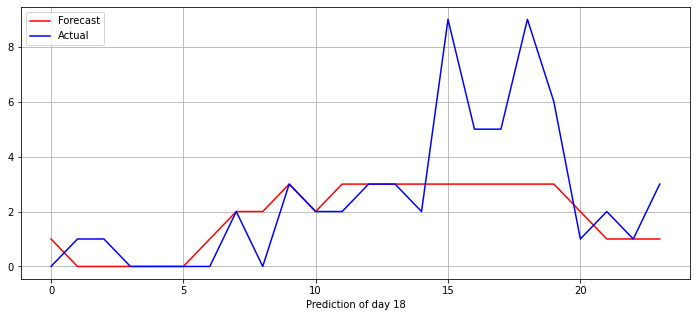

In [20]:
plotDayPrediction(df_predictions['31201_rentals'].values, df_Y_test['31201_rentals'].values, 18, False)

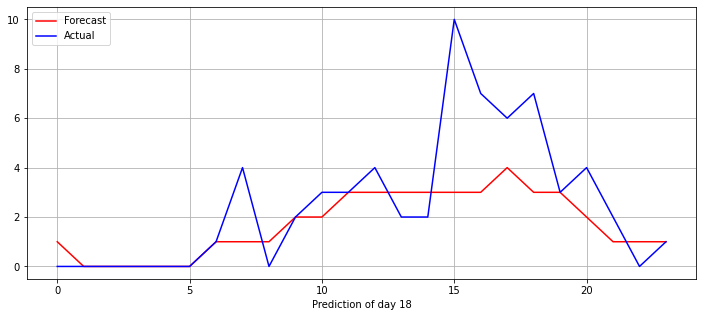

In [21]:
plotDayPrediction(df_predictions['31201_returns'].values, df_Y_test['31201_returns'].values, 18, False)

#### Adamax Optimizer

In [30]:
model = Sequential()

model.add(LSTM(Y_train.shape[2], input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
model.add(Dense(Y_train.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mae'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 1388)          31013472  
_________________________________________________________________
dense_1 (Dense)              (None, 24, 1388)          1927932   
Total params: 32,941,404
Trainable params: 32,941,404
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
with tf.device('/GPU:0'):
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
8/8 [==============================] - 5s 295ms/step - loss: 2.4071 - mae: 0.6435
Epoch 2/50
8/8 [==============================] - 2s 296ms/step - loss: 1.8872 - mae: 0.5877
Epoch 3/50
8/8 [==============================] - 2s 297ms/step - loss: 1.6862 - mae: 0.5331
Epoch 4/50
8/8 [==============================] - 2s 300ms/step - loss: 1.5767 - mae: 0.5062
Epoch 5/50
8/8 [==============================] - 2s 302ms/step - loss: 1.5095 - mae: 0.4896
Epoch 6/50
8/8 [==============================] - 2s 306ms/step - loss: 1.4562 - mae: 0.4753
Epoch 7/50
8/8 [==============================] - 2s 301ms/step - loss: 1.4135 - mae: 0.4664
Epoch 8/50
8/8 [==============================] - 2s 299ms/step - loss: 1.3778 - mae: 0.4580
Epoch 9/50
8/8 [==============================] - 2s 303ms/step - loss: 1.3471 - mae: 0.4515
Epoch 10/50
8/8 [==============================] - 2s 300ms/step - loss: 1.3199 - mae: 0.4463
Epoch 11/50
8/8 [==============================] - 2s 301ms/step - lo

In [32]:
score = model.evaluate(X_validation, Y_validation, batch_size=batch_size, verbose=0)
for i,metric in enumerate(model.metrics_names):
    if (metric =='loss'): print(' Test rmse: {}'.format( math.sqrt(score[i])))
    print(' Test {}: {}'.format(metric, score[i]))

 Test rmse: 1.0150175185171577
 Test loss: 1.0302605628967285
 Test mae: 0.4697500467300415


In [33]:
predictions = np.round(model.predict(X_validation))
predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1], predictions.shape[2])
df_predictions = pd.DataFrame(predictions, index=Y_validation_indexes, columns=Y_validation_columns)
Y_validation = Y_validation.reshape(Y_validation.shape[0]*Y_validation.shape[1], Y_validation.shape[2])
df_Y_validation = pd.DataFrame(Y_validation, index=Y_validation_indexes, columns=Y_validation_columns)

In [34]:
print('31201 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_rentals'].values, df_Y_validation['31201_rentals'].values))))
print('31201 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_returns'].values, df_Y_validation['31201_returns'].values))))
print('31200 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31200_rentals'].values, df_Y_validation['31200_rentals'].values))))
print('31200 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31200_returns'].values, df_Y_validation['31200_returns'].values))))
print('31101 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31101_rentals'].values, df_Y_validation['31101_rentals'].values))))
print('31101 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31101_returns'].values, df_Y_validation['31101_returns'].values))))
print('31230 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31230_rentals'].values, df_Y_validation['31230_rentals'].values))))
print('31230 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31230_returns'].values, df_Y_validation['31230_returns'].values))))
print('31611 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31611_rentals'].values, df_Y_validation['31611_rentals'].values))))
print('31611 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31611_returns'].values, df_Y_validation['31611_returns'].values))))

31201 Station rentals RMSE: 2.514500431159369
31201 Station returns RMSE: 2.4438130497691968
31200 Station rentals RMSE: 2.5347261393111467
31200 Station returns RMSE: 2.535129007559047
31101 Station rentals RMSE: 2.3372690896397916
31101 Station returns RMSE: 2.0902825277343813
31230 Station rentals RMSE: 1.7229468220563242
31230 Station returns RMSE: 1.9609129859741588
31611 Station rentals RMSE: 1.432580741773163
31611 Station returns RMSE: 1.4430926303842317


#### - TEST evaluation

In [35]:
score = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
for i,metric in enumerate(model.metrics_names):
    if (metric =='loss'): print(' Test rmse: {}'.format( math.sqrt(score[i])))
    print(' Test {}: {}'.format(metric, score[i]))

 Test rmse: 0.797352329980196
 Test loss: 0.6357707381248474
 Test mae: 0.33957770466804504


In [36]:
predictions = np.round(model.predict(X_test))
predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1], predictions.shape[2])
df_predictions = pd.DataFrame(predictions, index=Y_test_indexes, columns=Y_test_columns)
Y_test = Y_test.reshape(Y_test.shape[0]*Y_test.shape[1], Y_test.shape[2])
df_Y_test = pd.DataFrame(Y_test, index=Y_test_indexes, columns=Y_test_columns)

In [37]:
print('31201 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_rentals'].values, df_Y_test['31201_rentals'].values))))
print('31201 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_returns'].values, df_Y_test['31201_returns'].values))))
print('31200 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31200_rentals'].values, df_Y_test['31200_rentals'].values))))
print('31200 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31200_returns'].values, df_Y_test['31200_returns'].values))))
print('31101 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31101_rentals'].values, df_Y_test['31101_rentals'].values))))
print('31101 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31101_returns'].values, df_Y_test['31101_returns'].values))))
print('31230 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31230_rentals'].values, df_Y_test['31230_rentals'].values))))
print('31230 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31230_returns'].values, df_Y_test['31230_returns'].values))))
print('31611 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31611_rentals'].values, df_Y_test['31611_rentals'].values))))
print('31611 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31611_returns'].values, df_Y_test['31611_returns'].values))))

31201 Station rentals RMSE: 1.9431251359903836
31201 Station returns RMSE: 1.9406007761899458
31200 Station rentals RMSE: 1.6378638646773078
31200 Station returns RMSE: 1.9447011968675392
31101 Station rentals RMSE: 1.7769861391024104
31101 Station returns RMSE: 1.8328876463610655
31230 Station rentals RMSE: 1.2227420166231657
31230 Station returns RMSE: 1.4595583090498099
31611 Station rentals RMSE: 1.0650800086550312
31611 Station returns RMSE: 1.1710352383304974


#### - Visualization

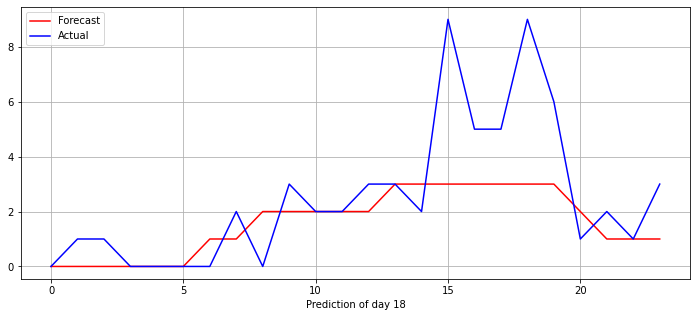

In [38]:
plotDayPrediction(df_predictions['31201_rentals'].values, df_Y_test['31201_rentals'].values, 18, False)

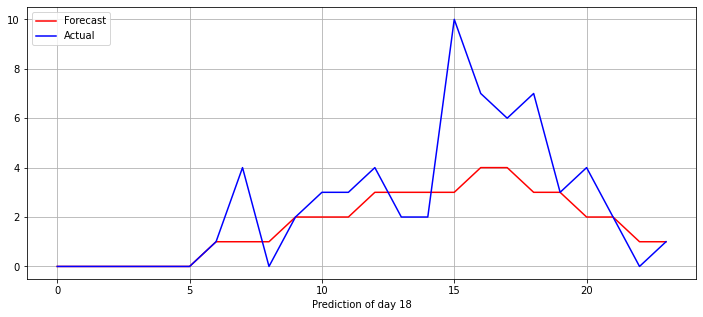

In [39]:
plotDayPrediction(df_predictions['31201_returns'].values, df_Y_test['31201_returns'].values, 18, False)

#### Adamax Optimizer / LOG1P Data

In [11]:
model = Sequential()

model.add(LSTM(Y_train.shape[2], input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
model.add(Dense(Y_train.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mae'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 1388)          31013472  
_________________________________________________________________
dense (Dense)                (None, 24, 1388)          1927932   
Total params: 32,941,404
Trainable params: 32,941,404
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
with tf.device('/GPU:0'):
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
8/8 [==============================] - 7s 291ms/step - loss: 0.2436 - mae: 0.3309
Epoch 2/50
8/8 [==============================] - 2s 304ms/step - loss: 0.1567 - mae: 0.2542
Epoch 3/50
8/8 [==============================] - 2s 294ms/step - loss: 0.1358 - mae: 0.2303
Epoch 4/50
8/8 [==============================] - 2s 292ms/step - loss: 0.1235 - mae: 0.2132
Epoch 5/50
8/8 [==============================] - 2s 287ms/step - loss: 0.1171 - mae: 0.2016
Epoch 6/50
8/8 [==============================] - 2s 289ms/step - loss: 0.1127 - mae: 0.1950
Epoch 7/50
8/8 [==============================] - 2s 288ms/step - loss: 0.1087 - mae: 0.1899
Epoch 8/50
8/8 [==============================] - 2s 289ms/step - loss: 0.1049 - mae: 0.1856
Epoch 9/50
8/8 [==============================] - 2s 288ms/step - loss: 0.1020 - mae: 0.1819
Epoch 10/50
8/8 [==============================] - 2s 290ms/step - loss: 0.0998 - mae: 0.1790
Epoch 11/50
8/8 [==============================] - 2s 286ms/step - lo

In [13]:
score = model.evaluate(X_validation, Y_validation, batch_size=batch_size, verbose=0)

for i,metric in enumerate(model.metrics_names):
    if (metric =='loss'):
        print(' Test rmse: {}'.format( math.sqrt(score[i])))
    print(' Test {}: {}'.format(metric, score[i]))

 Test rmse: 0.3468033690853211
 Test loss: 0.12027257680892944
 Test mae: 0.2073768973350525


In [14]:
predictions = np.round(model.predict(X_validation))
predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1], predictions.shape[2])
df_predictions = pd.DataFrame(predictions, index=Y_validation_indexes, columns=Y_validation_columns)
df_predictions = round(np.expm1(df_predictions))
Y_validation = Y_validation.reshape(Y_validation.shape[0]*Y_validation.shape[1], Y_validation.shape[2])
df_Y_validation = pd.DataFrame(Y_validation, index=Y_validation_indexes, columns=Y_validation_columns)
df_Y_validation = np.expm1(df_Y_validation)

In [15]:
print('31201 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_rentals'].values, df_Y_validation['31201_rentals'].values))))
print('31201 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_returns'].values, df_Y_validation['31201_returns'].values))))

31201 Station rentals RMSE: 2.8815108146879127
31201 Station returns RMSE: 2.890145528597235


#### - TEST evaluation

In [34]:
score = model.evaluate(X_test, Y_test, batch_size=batch_size,verbose=0)

for i,metric in enumerate(model.metrics_names):
    if (metric =='loss'):
        print(' Test rmse: {}'.format( math.sqrt(score[i])))
    print(' Test {}: {}'.format(metric, score[i]))

 Test rmse: 0.29874657160096607
 Test loss: 0.08924951404333115
 Test mae: 0.1626519411802292


In [18]:
predictions = model.predict(X_test)
predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1], predictions.shape[2])
df_predictions = pd.DataFrame(predictions, index=Y_test_indexes, columns=Y_test_columns)
df_predictions = round(np.expm1(df_predictions))
Y_test = Y_test.reshape(Y_test.shape[0]*Y_test.shape[1], Y_test.shape[2])
df_Y_test = pd.DataFrame(Y_test, index=Y_test_indexes, columns=Y_test_columns)
df_Y_test = np.expm1(df_Y_test)

In [19]:
print('31201 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_rentals'].values, df_Y_test['31201_rentals'].values))))
print('31201 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_returns'].values, df_Y_test['31201_returns'].values))))

31201 Station rentals RMSE: 2.093407017561676
31201 Station returns RMSE: 1.9453312636901192


### Adamax Optimizer / Bigger Dense Layer / LOG1P Data

In [29]:
model = Sequential()

model.add(LSTM(2048, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
model.add(Dense(2048, activation='relu'))
model.add(Dense(Y_train.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mae'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 2048)          51167232  
_________________________________________________________________
dense_1 (Dense)              (None, 24, 2048)          4196352   
_________________________________________________________________
dense_2 (Dense)              (None, 24, 1388)          2844012   
Total params: 58,207,596
Trainable params: 58,207,596
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
with tf.device('/GPU:0'):
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
8/8 [==============================] - 5s 465ms/step - loss: 0.2020 - mae: 0.2864
Epoch 2/50
8/8 [==============================] - 4s 481ms/step - loss: 0.1267 - mae: 0.2080
Epoch 3/50
8/8 [==============================] - 4s 470ms/step - loss: 0.1158 - mae: 0.1882
Epoch 4/50
8/8 [==============================] - 4s 471ms/step - loss: 0.1123 - mae: 0.1823
Epoch 5/50
8/8 [==============================] - 4s 466ms/step - loss: 0.1095 - mae: 0.1778
Epoch 6/50
8/8 [==============================] - 4s 469ms/step - loss: 0.1065 - mae: 0.1745
Epoch 7/50
8/8 [==============================] - 4s 469ms/step - loss: 0.1029 - mae: 0.1717
Epoch 8/50
8/8 [==============================] - 4s 472ms/step - loss: 0.0992 - mae: 0.1684
Epoch 9/50
8/8 [==============================] - 4s 473ms/step - loss: 0.0964 - mae: 0.1658
Epoch 10/50
8/8 [==============================] - 4s 474ms/step - loss: 0.0943 - mae: 0.1636
Epoch 11/50
8/8 [==============================] - 4s 475ms/step - lo

In [31]:
score = model.evaluate(X_validation, Y_validation, batch_size=batch_size, verbose=0)

for i,metric in enumerate(model.metrics_names):
    if (metric =='loss'):
        print(' Test rmse: {}'.format( math.sqrt(score[i])))
    print(' Test {}: {}'.format(metric, score[i]))

 Test rmse: 0.3470058142947214
 Test loss: 0.12041303515434265
 Test mae: 0.20630519092082977


In [32]:
predictions = np.round(model.predict(X_validation))
predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1], predictions.shape[2])
df_predictions = pd.DataFrame(predictions, index=Y_validation_indexes, columns=Y_validation_columns)
df_predictions = round(np.expm1(df_predictions))
Y_validation = Y_validation.reshape(Y_validation.shape[0]*Y_validation.shape[1], Y_validation.shape[2])
df_Y_validation = pd.DataFrame(Y_validation, index=Y_validation_indexes, columns=Y_validation_columns)
df_Y_validation = np.expm1(df_Y_validation)

In [33]:
print('31201 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_rentals'].values, df_Y_validation['31201_rentals'].values))))
print('31201 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_returns'].values, df_Y_validation['31201_returns'].values))))

31201 Station rentals RMSE: 2.8474274595246323
31201 Station returns RMSE: 2.82806603818579


#### - TEST evaluation

In [35]:
score = model.evaluate(X_test, Y_test, batch_size=batch_size,verbose=0)

for i,metric in enumerate(model.metrics_names):
    if (metric =='loss'):
        print(' Test rmse: {}'.format( math.sqrt(score[i])))
    print(' Test {}: {}'.format(metric, score[i]))

 Test rmse: 0.29874657160096607
 Test loss: 0.08924951404333115
 Test mae: 0.1626519411802292


In [36]:
predictions = model.predict(X_test)
predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1], predictions.shape[2])
df_predictions = pd.DataFrame(predictions, index=Y_test_indexes, columns=Y_test_columns)
df_predictions = round(np.expm1(df_predictions))
Y_test = Y_test.reshape(Y_test.shape[0]*Y_test.shape[1], Y_test.shape[2])
df_Y_test = pd.DataFrame(Y_test, index=Y_test_indexes, columns=Y_test_columns)
df_Y_test = np.expm1(df_Y_test)

In [37]:
print('31201 Station rentals RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_rentals'].values, df_Y_test['31201_rentals'].values))))
print('31201 Station returns RMSE: {}'.format(math.sqrt(mean_squared_error(df_predictions['31201_returns'].values, df_Y_test['31201_returns'].values))))

31201 Station rentals RMSE: 2.06758755574065
31201 Station returns RMSE: 1.940916500714314
